In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import zipfile
# from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
# from model import VAE

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics

from models.auto_encoder import AutoEncoder
from dataloader.animal_faces import AnimalfaceDataset

device = torch.device("cuda")
cpu_device = torch.device("cpu")

%reload_ext autoreload
%autoreload 2

/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
width = 128

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])
train_data = AnimalfaceDataset(transform=transform)

  0%|                                                                                                                           | 0/14630 [00:00<?, ?it/s]/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████

In [7]:
val_data = AnimalfaceDataset(transform=transform, type="val")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 208.59it/s]


In [35]:
BATCH_SIZE = 2048
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([2048, 3, 128, 128]), torch.Size([2048]))

In [108]:
width = 128
feature_size = 128
filters = [3, 16, 32, 64, 128, 256]
kernel_sizes = [4, 4, 4, 4, 4]
strides = [2,2,2,2,2]
paddings = [0,0,0,0,0]
output_paddings = [0,1,0,0,0]
# paddings = [0,0]
return_only_liner = 0
dropout_prob = 0.3

if return_only_liner:
    conv_ip_size = (3, 128, 128)
    hidden_sizes = [128*128*3, 4096, feature_size]
else:
    conv_ip_size = (256,2,2)
#     hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], 256*3, 256, feature_size]
    hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], feature_size]    

In [109]:
ae = AutoEncoder(feature_size=feature_size, conv_ip_size=conv_ip_size, filters=filters, 
                 kernel_sizes=kernel_sizes,strides=strides,output_paddings=output_paddings, 
                 paddings=paddings, hiddens_sizes=hidden_sizes, return_only_liner=return_only_liner, droput_prob=dropout_prob).to(device)
op, enc = ae(x.to(device))
print(op.shape, enc.shape)

# summary(ae, (3,32,32), device="cuda")
summary(ae, (3,width,width), device="cuda")

[128, 1024]
torch.Size([2048, 3, 128, 128]) torch.Size([2048, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 63, 63]             784
              ReLU-2           [-1, 16, 63, 63]               0
            Conv2d-3           [-1, 32, 30, 30]           8,224
              ReLU-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 14, 14]          32,832
              ReLU-6           [-1, 64, 14, 14]               0
            Conv2d-7            [-1, 128, 6, 6]         131,200
              ReLU-8            [-1, 128, 6, 6]               0
            Conv2d-9            [-1, 256, 2, 2]         524,544
             ReLU-10            [-1, 256, 2, 2]               0
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 128]         131,200
          Encoder-13               

In [110]:
ae.load_state_dict(torch.load( f"ckpts/autoencoder_{feature_size}_1l.pt"))

<All keys matched successfully>

In [111]:
def get_latents(ae, dataloader, device=torch.device("cuda")):
    temp, labels = [], []
    for X,y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            ae.eval()
            enc = ae.encoder(X)
            temp.append(enc)
            labels.extend(y)
    latents = torch.cat(temp).to(device)
    return latents, torch.tensor(labels)

In [113]:
train_latents, train_labels = get_latents(ae, train_loader)
val_latents, val_labels = get_latents(ae, val_loader)
print(train_latents.shape, val_latents.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]

torch.Size([14630, 128]) torch.Size([1500, 128])


In [115]:
class Classifier(nn.Module):
    def __init__(self, hiddens_sizes = [2048, 1024, 512, 256, 3]):
        super(Classifier, self).__init__()
        hidden_layers = []
        for i in range(len(hiddens_sizes)-1):
            hidden_layers.append(nn.Linear(hiddens_sizes[i], hiddens_sizes[i+1]))
#             hidden_layers.append(nn.Dropout(p=0.15))
            if i < len(hiddens_sizes)-2:
                hidden_layers.append(nn.ReLU(True))
            
        self.liner_layer = nn.Sequential(*(hidden_layers[:-1]))
        
    def forward(self, x):
        logits = self.liner_layer(x)
        y_log_probs = F.log_softmax(logits, dim=-1)
        y_pred = torch.argmax(y_log_probs, dim=-1)
        return logits, y_log_probs, y_pred
    
cl = Classifier(hiddens_sizes = [feature_size,64,3]).to(device)
optim = torch.optim.Adam(cl.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [116]:
n_epochs = 1000
tqdm_obj = tqdm(range(n_epochs))
train_losses = []
val_losses = []
for epoch in tqdm_obj:
    # train
    cl.train()
    optim.zero_grad()
    logits, log_prob, y_pred = cl(train_latents)
    loss = loss_fn(logits, train_labels.type(torch.LongTensor).to(device))
    loss.backward()
    optim.step()
    train_losses.append(loss)
    
    # val
    cl.eval()
    with torch.no_grad():
        val_logits, val_log_prob, val_y_pred = cl(val_latents)
        val_loss = loss_fn(val_log_prob, val_labels.type(torch.LongTensor).to(device))
        val_losses.append(val_loss)
    
    tqdm_obj.set_description_str(f"Epoch: {epoch} Train loss: {loss} Val loss: {val_loss}")
    

Epoch: 999 Train loss: 0.8847980499267578 Val loss: 0.9215441346168518: 100%|████████████████████████████████████████| 1000/1000 [00:01<00:00, 750.53it/s]


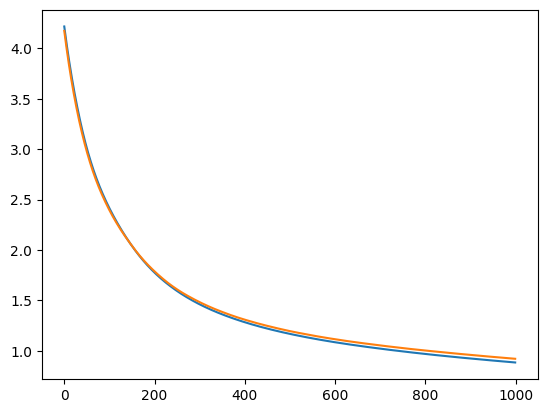

In [117]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
plt.plot(to_cpu(train_losses))
plt.plot(to_cpu(val_losses))

In [118]:
torchmetrics.Accuracy(task="multiclass", num_classes=3)(val_y_pred.to(cpu_device), val_data.labels)

tensor(0.3440)

In [119]:
torchmetrics.Accuracy(task="multiclass", num_classes=3)(y_pred.to(cpu_device), train_data.labels)

tensor(0.3352)

In [120]:
torchmetrics.ConfusionMatrix(task="multiclass", num_classes=3)(val_y_pred.to(cpu_device), val_data.labels)

tensor([[173, 175, 152],
        [176, 169, 155],
        [167, 159, 174]])